### Import libraries

In [1]:
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup

In [2]:
# Load data from wiki url
url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
source = requests.get(url).text
data = BeautifulSoup(source, 'lxml')

In [3]:
# Create DataFrame
cols = ['Postalcode', 'Borough', 'Neighbourhood']
toronto_df = pd.DataFrame(columns = cols)

In [4]:
# For loop to find content in the columns
content = data.find('div', class_='mw-parser-output')
table = content.table.tbody

postalcode = 0
borough = 0
neighbourhood = 0

for tr in table.find_all('tr'):
    i = 0
    for td in tr.find_all('td'):
        if i == 0:
            postalcode = td.text
            i += 1
        elif i == 1:
            borough = td.text
            i += 1
        elif i == 2:
            neighbourhood = td.text.strip('\n').replace(']', '')
    toronto_df = toronto_df.append({'Postalcode': postalcode, 'Borough': borough, 'Neighbourhood': neighbourhood}, ignore_index=True)

toronto_df.head()

,Postalcode,Borough,Neighbourhood
0,0,0,0
1,M1A,Not assigned,Not assigned
2,M2A,Not assigned,Not assigned
3,M3A,North York,Parkwoods
4,M4A,North York,Victoria Village


In [5]:
# DataFrame Cleaning
toronto_df = toronto_df[toronto_df.Borough != 'Not assigned']
toronto_df = toronto_df[toronto_df.Borough != 0]

toronto_df.reset_index(drop=True, inplace=True)

# If Neighbourhood content is 'Not assigned' means it is same as the content in Borough
i = 0
for i in range(0, toronto_df.shape[0]):
    if toronto_df.iloc[i][2] == 'Not assigned':
        toronto_df.iloc[i][2] = toronto_df.iloc[i][1]
        i += 1

df = toronto_df.groupby(['Postalcode', 'Borough'])['Neighbourhood'].apply(', '.join).reset_index()
df.head()

,Postalcode,Borough,Neighbourhood
0,M1B,Scarborough,"Rouge, Malvern"
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


In [6]:
# Drop None value and replace 'Not assigned' with 'NaN'
df = df.dropna()
df = df[(df.Postalcode != 'Not assigned') & (df.Borough != 'Not assigned') & (df.Neighbourhood != 'Not assigned')]

df.head()

,Postalcode,Borough,Neighbourhood
0,M1B,Scarborough,"Rouge, Malvern"
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


In [7]:
def neighbourhood_list(groupedDataframe):
    return ', '.join(sorted(groupedDataframe['Neighbourhood'].tolist()))

grouped_df = df.groupby(['Postalcode', 'Borough'])
new_df = grouped_df.apply(neighbourhood_list).reset_index(name='Neighbourhood')

new_df.head()

,Postalcode,Borough,Neighbourhood
0,M1B,Scarborough,"Rouge, Malvern"
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


### Install / Import Geocoder

In [8]:
!pip install geocoder
import geocoder

In [9]:
# Find out the cooordinates based on Postal Code
def coordinates(postalCode):
    lat_lng = None
    while(lat_lng is None):
        g = geocoder.arcgis('{}, Toronto, ON'.format(postalCode))
        lat_lng = g.latlng
    return lat_lng

coordinates('M4G')

[43.70949500000006, -79.36398897099997]

In [10]:
postal_codes = new_df['Postalcode']
coords = [coordinates(i) for i in postal_codes.tolist()]

# Create new cols - Latitude and Longitude
coordinates_df = pd.DataFrame(coords, columns=['Latitude', 'Longitude'])

# Add new cols to 'new_df' Dataframe
new_df['Latitude'] = coordinates_df['Latitude']
new_df['Longitude'] = coordinates_df['Longitude']

new_df.head()

,Postalcode,Borough,Neighbourhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge, Malvern",43.811525,-79.195517
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.785665,-79.158725
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.765815,-79.175193
3,M1G,Scarborough,Woburn,43.768369,-79.217590
4,M1H,Scarborough,Cedarbrae,43.769688,-79.239440


### Import new libraries

In [11]:
import requests
from bs4 import BeautifulSoup as bs
import re

import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json
from pandas.io.json import json_normalize  # transform Json file into a pandas dataframe 

!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim  # convert an address into latitude and longitude values

import matplotlib.cm as cm
import matplotlib.colors as colors

from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes
import folium

Solving environment: ...working... done

# All requested packages already installed.

Solving environment: ...working... done

# All requested packages already installed.



In [12]:
address = 'Toronto'

geolocator = Nominatim()
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

print('The coordinate of Toronto >>> Latitude: {}, Longitude: {}'.format(latitude, longitude))

# Create a map of Toronto
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# Add markers to the map
for lat, lng, borough, neighbourhood in zip(new_df['Latitude'], new_df['Longitude'], new_df['Borough'], new_df['Neighbourhood']):
    str_label = '{}, {}'.format(neighbourhood, borough)
    label = folium.Popup(str_label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False
    ).add_to(map_toronto)
    
map_toronto    

C:\Users\Jabin Choi\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: Using Nominatim with the default "geopy/1.20.0" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  This is separate from the ipykernel package so we can avoid doing imports until


The coordinate of Toronto >>> Latitude: 43.653963, Longitude: -79.387207


In [13]:
scarborough_data = new_df[new_df['Borough'] == 'Scarborough'].reset_index(drop=True)
scarborough_address = 'Scarborough, Toronto'

geolocator2 = Nominatim()
location2 = geolocator2.geocode(scarborough_address)
latitude2 = location2.latitude
longitude2 = location2.longitude

print('The coordinate of Scarborough >>>> Latitude: {}, Longitude: {}'.format(latitude2, longitude2))

C:\Users\Jabin Choi\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: Using Nominatim with the default "geopy/1.20.0" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  after removing the cwd from sys.path.


The coordinate of Scarborough >>>> Latitude: 43.773077, Longitude: -79.257774


In [14]:
map_scarborough = folium.Map(location=[latitude2, longitude2], zoom_start=11)

# Add markders to the map
for lat, lng, neighbourhoods in zip(scarborough_data['Latitude'], scarborough_data['Longitude'], scarborough_data['Neighbourhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=4,
        popup=label,
        color='red',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False
    ).add_to(map_toronto)

map_scarborough

In [15]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
    
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [16]:
CLIENT_ID = '0MJA3NYYG3U2ZY1LTZN2OYEHS3Y3WVSON2GBSO3IL4EDYVIR' # your Foursquare ID
CLIENT_SECRET = 'WGWSAF2TKVUQPE3PD0N3EOITFVBY5EYP1VCZI3BMUG0ROUS5' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

LIMIT=100
radius=500

url='https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude2, longitude2, VERSION, radius, LIMIT)

In [17]:
results = requests.get(url).json()
venues = results['response']['groups'][0]['items']

nearby_venues = json_normalize(venues)

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,SEPHORA,Cosmetics Shop,43.775017,-79.258109
1,Disney Store,Toy / Game Store,43.775537,-79.256833
2,American Eagle Outfitters,Clothing Store,43.776012,-79.258334
3,DAVIDsTEA,Tea Room,43.776613,-79.258516
4,Hot Topic,Clothing Store,43.775450,-79.257929


In [18]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [19]:
scarborough_venues = getNearbyVenues(
                                    names=scarborough_data['Neighbourhood'],
                                    latitudes=scarborough_data['Latitude'],
                                    longitudes=scarborough_data['Longitude']
                                  )

Rouge, Malvern
Highland Creek, Rouge Hill, Port Union
Guildwood, Morningside, West Hill
Woburn
Cedarbrae
Scarborough Village
East Birchmount Park, Ionview, Kennedy Park
Clairlea, Golden Mile, Oakridge
Cliffcrest, Cliffside, Scarborough Village West
Birch Cliff, Cliffside West
Dorset Park, Scarborough Town Centre, Wexford Heights
Maryvale, Wexford
Agincourt
Clarks Corners, Sullivan, Tam O'Shanter
Agincourt North, L'Amoreaux East, Milliken, Steeles East
L'Amoreaux West
Upper Rouge


### Top 10 venues per neighbourhood

In [20]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [21]:
# Encoding
scarb_onehot = pd.get_dummies(scarborough_venues[['Venue Category']], prefix="", prefix_sep="")

# Add Neighbourhood column back to dataframe
scarb_onehot['Neighbourhood'] = scarborough_venues['Neighbourhood'] 

# Move neighbourhood column to the first column
fixed_columns = [scarb_onehot.columns[-1]] + list(scarb_onehot.columns[:-1])
scarb_onehot = scarb_onehot[fixed_columns]

scarb_grouped = scarb_onehot.groupby('Neighbourhood').mean().reset_index()

In [22]:
number_top_venues = 10
indicator = ['st', 'nd', 'rd']
columns = ['Neighbourhood']

for i in np.arange(number_top_venues):
    try:
        columns.append('{}{} Most common venue'.format(i+1, indicator[i]))
    except:
        columns.append('{}th Most common venue'.format(i+1))

# Create a new dataframe
sorted_neighbour_venues = pd.DataFrame(columns=columns)
sorted_neighbour_venues['Neighbourhood'] = scarb_grouped['Neighbourhood']

for i in np.arange(scarb_grouped.shape[0]):
    sorted_neighbour_venues.iloc[i, 1:] = return_most_common_venues(scarb_grouped.iloc[i, :], number_top_venues)

sorted_neighbour_venues.head()

,Neighbourhood,1st Most common venue,2nd Most common venue,3rd Most common venue,4th Most common venue,5th Most common venue,6th Most common venue,7th Most common venue,8th Most common venue,9th Most common venue,10th Most common venue
0,Agincourt,Chinese Restaurant,Shopping Mall,Vietnamese Restaurant,Skating Rink,Park,Discount Store,Pool,Shanghai Restaurant,Supermarket,Sushi Restaurant
1,"Agincourt North, L'Amoreaux East, Milliken, St...",Pharmacy,Vietnamese Restaurant,Gym Pool,Gym,Grocery Store,Golf Course,Gift Shop,General Entertainment,Fried Chicken Joint,Flower Shop
2,"Birch Cliff, Cliffside West",Gym Pool,Gym,General Entertainment,Skating Rink,Park,College Stadium,Department Store,Grocery Store,Golf Course,Gift Shop
3,Cedarbrae,Playground,Trail,Vietnamese Restaurant,Grocery Store,Golf Course,Gift Shop,General Entertainment,Fried Chicken Joint,Flower Shop,Fast Food Restaurant
4,"Clairlea, Golden Mile, Oakridge",Bakery,Bus Line,Intersection,Soccer Field,Bus Station,Coffee Shop,Metro Station,Vietnamese Restaurant,Discount Store,Grocery Store


### K-Means - 5 clusters

In [23]:
scarb_data = scarborough_data.drop(16)

k = 5

scarb_grouped_clustering = scarb_grouped.drop('Neighbourhood', 1)

# Run K-Means Clustering
kmeans = KMeans(n_clusters=k, random_state=0).fit(scarb_grouped_clustering)

scarb_merged = scarb_data

# Add clustering labels
scarb_merged['Labels'] = kmeans.labels_

# Merge toronto_grouped with toronto_data - To add latitude / longitude for each Neighbourhood
scarb_merged = scarb_merged.join(sorted_neighbour_venues.set_index('Neighbourhood'), on='Neighbourhood')
scarb_merged.head()

,Postalcode,Borough,Neighbourhood,Latitude,Longitude,Labels,1st Most common venue,2nd Most common venue,3rd Most common venue,4th Most common venue,5th Most common venue,6th Most common venue,7th Most common venue,8th Most common venue,9th Most common venue,10th Most common venue
0,M1B,Scarborough,"Rouge, Malvern",43.811525,-79.195517,0,Home Service,Vietnamese Restaurant,Gym Pool,Gym,Grocery Store,Golf Course,Gift Shop,General Entertainment,Fried Chicken Joint,Flower Shop
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.785665,-79.158725,2,Bar,Golf Course,Vietnamese Restaurant,Convenience Store,Gym,Grocery Store,Gift Shop,General Entertainment,Fried Chicken Joint,Flower Shop
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.765815,-79.175193,0,Gym / Fitness Center,Park,Construction & Landscaping,Department Store,Gym,Grocery Store,Golf Course,Gift Shop,General Entertainment,Fried Chicken Joint
3,M1G,Scarborough,Woburn,43.768369,-79.217590,4,Korean Restaurant,Business Service,Coffee Shop,Park,Vietnamese Restaurant,Department Store,Grocery Store,Golf Course,Gift Shop,General Entertainment
4,M1H,Scarborough,Cedarbrae,43.769688,-79.239440,0,Playground,Trail,Vietnamese Restaurant,Grocery Store,Golf Course,Gift Shop,General Entertainment,Fried Chicken Joint,Flower Shop,Fast Food Restaurant


### Visualization

In [24]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# Colours scheme for clusters
x = np.arange(k)
ys = [i+x+(i*x)**2 for i in range(k)]
colors_arr = cm.rainbow(np.linspace(0,1,len(ys)))
rainbow=[colors.rgb2hex(i) for i in colors_arr]

# Add markers to the map
markers_colors = []

for lat, lng, poi, cluster in zip(scarb_merged['Latitude'], scarb_merged['Longitude'], scarb_merged['Neighbourhood'], scarb_merged['Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7
    ).add_to(map_clusters)
       
map_clusters

In [25]:
df1 = scarb_merged.loc[scarb_merged['Labels']==0, scarb_merged.columns[[2] + list(range(5, scarb_merged.shape[1]))]]
df2 = scarb_merged.loc[scarb_merged['Labels']==1, scarb_merged.columns[[2] + list(range(5, scarb_merged.shape[1]))]]
df3 = scarb_merged.loc[scarb_merged['Labels']==2, scarb_merged.columns[[2] + list(range(5, scarb_merged.shape[1]))]]
df4 = scarb_merged.loc[scarb_merged['Labels']==3, scarb_merged.columns[[2] + list(range(5, scarb_merged.shape[1]))]]
df5 = scarb_merged.loc[scarb_merged['Labels']==4, scarb_merged.columns[[2] + list(range(5, scarb_merged.shape[1]))]]

### Average of housing price

In [32]:
scarb_merged = new_df.loc[:16, :]
scarb_merged.shape

(17, 5)

In [33]:
data_housing_price = [335000.0, 286600.0, 175000.0, 225900.0, 219400.0,
                            573900.0, 225000.0, 370500.0, 370500.0, 433500.0, 279200.0,
                            279200.0, 225000.0, 370500., 255400.0, 433500.0, 433500.0]

df_average_housing_price = pd.DataFrame(
    {'Neighbourhood': scarb_merged['Neighbourhood'],
    'Average_Housing_Price': data_housing_price}
)

df_average_housing_price.head()

,Neighbourhood,Average_Housing_Price
0,"Rouge, Malvern",335000.0
1,"Highland Creek, Rouge Hill, Port Union",286600.0
2,"Guildwood, Morningside, West Hill",175000.0
3,Woburn,225900.0
4,Cedarbrae,219400.0


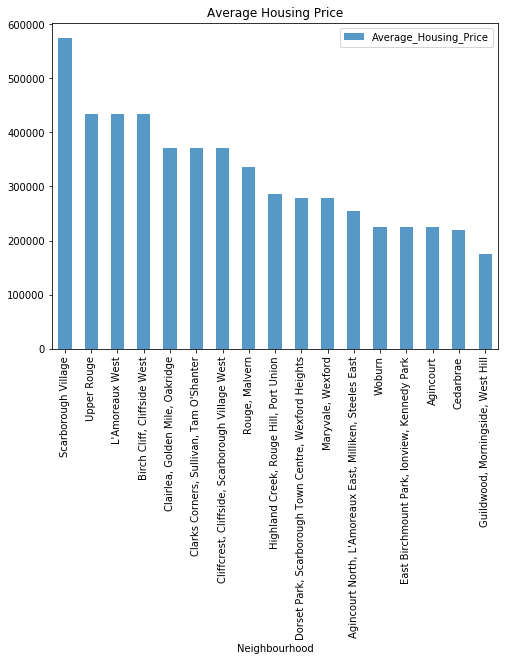

In [34]:
# Ready to plot the data - Let's make a barplot
df_average_housing_price.sort_values('Average_Housing_Price', axis=0, ascending=False, inplace=True)
df_average_housing_price.set_index('Neighbourhood', inplace=True)
df_average_housing_price.plot(kind='bar', title='Average Housing Price', figsize=(8,6),alpha=0.75)

### School Rates by clusters (k=5)

In [29]:
df_clusters = pd.DataFrame({'k=1': df1['Neighbourhood'],
                                           'k=2': df2['Neighbourhood'],
                                           'k=3': df3['Neighbourhood'],
                                           'k=4': df4['Neighbourhood'],
                                           'k=5': df5['Neighbourhood']})
df_clusters = df_clusters.replace(np.nan, '', regex=True)
df_clusters.head()

,k=1,k=2,k=3,k=4,k=5
0,"Rouge, Malvern",,,,
1,,,"Highland Creek, Rouge Hill, Port Union",,
2,"Guildwood, Morningside, West Hill",,,,
3,,,,,Woburn
4,Cedarbrae,,,,


In [30]:
new_scarb_df = scarb_merged.set_index('Neighbourhood', drop=True)

school_rates_data = [7,9,5,8,10,10,7,10,1,2,1,2,7,2,3,2,6]
df_school_rates = pd.DataFrame({'Neighbourhood': scarb_merged['Neighbourhood'],
                                           'Top School Rates': school_rates_data})

df_school_rates.head()

,Neighbourhood,Top School Rates
0,"Rouge, Malvern",7
1,"Highland Creek, Rouge Hill, Port Union",9
2,"Guildwood, Morningside, West Hill",5
3,Woburn,8
4,Cedarbrae,10


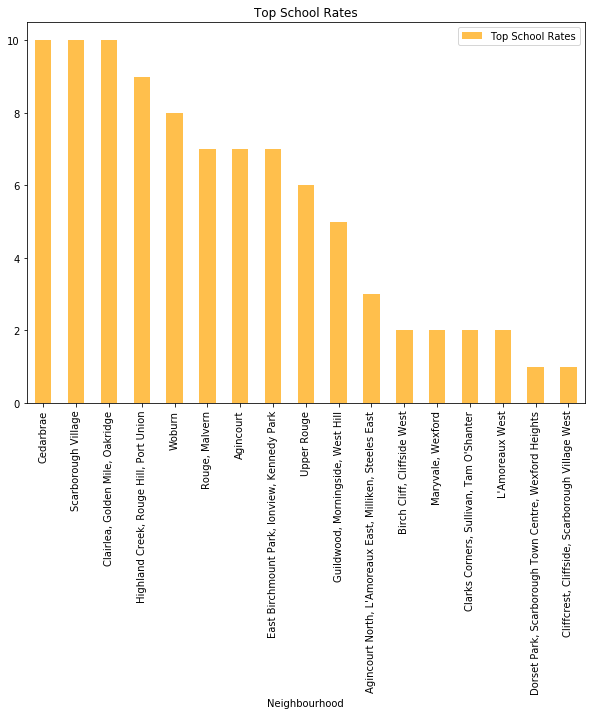

In [31]:
# Data is ready to make a barplot
df_school_rates.sort_values('Top School Rates', ascending=False, inplace=True)
df_school_rates.set_index('Neighbourhood', inplace=True, drop=True)
df_school_rates.plot(kind='bar', title='Top School Rates', figsize=(10,7), color='orange', alpha=0.7)